In [1]:
from itertools import product
from math import exp
import numpy as np
from numba import njit, prange

In [2]:
@njit
def int2array(x: int, L: int) -> np.ndarray:
    '''
    Takes x - number that should be represanted as array of 1 and -1, L - length of array
    Transform number x to array fo 1 and -1 by next rule: if the current last bit is 1 then leave 1 if 0 then put -1 afterwards go on to the next bit.
    return array of 1 and -1.
    '''
    res = np.empty(L, dtype=np.int8)
    for i in range(L):
        res[i] = (x & 1) * 2 - 1
        x = x >> 1
    return res

In [3]:
# This one for working with prod
# def get_range(a : int, b : int) -> np.array:
#     '''
#     Takes a - left 
#     get_range takes a and b and return range(a, b, 1). The difference is that this one return list.
#     '''
#     res = []
#     while a <= b:
#         res.append(a)
#         a += 1
#     return res

In [4]:

class find_mean_energy_for_1d:
    def int2array(self, x: int, L: int) -> np.ndarray:
        '''
        Takes x - number that should be represanted as array of 1 and -1, L - length of array
        Transform number x to array fo 1 and -1 by next rule: if the current last bit is 1 then leave 1 if 0 then put -1 afterwards go on to the next bit.
        return array of 1 and -1.
        '''
        res = np.empty(L, dtype=np.int8)
        for i in range(L):
            res[i] = (x & 1) * 2 - 1
            x = x >> 1
        return res
    def energy(self, sigma: np.ndarray) -> int:
        '''
        Takes sigma - array of 1 and -1. 
        The function treats it as a spin orientation of according electrons. The function calculates energy of the system of electrons with that 
        specific spin orientation.
        Return the energy of set of electrons when the spin orientation accords to sigma. 
        '''
        E = 0
        n = len(sigma)
        for i in range(n):
            E -= sigma[i] * sigma[(i + 1) % n]
        return E
    def mean_energy(self, L: int, kT: np.array) -> float:
        '''
        Takes L - number of electrons, kT - the product of The Boltzmann constant and temperature.
        Calculate mean energy of system with L electrons when system can be represanted with 1d array.
        Return the mean energy of set of electrons with spin orientation according to sigma and with 
        the product of The Boltzmann constant and temperature equal to  kT.
        '''
        E_mean = 0
        Z = 0
        for sigma in prange(2**(L-1)):
            E = self.energy(int2array(sigma, L))
            e = exp(-E / kT)
            E_mean += E * e
            Z += e
        E_mean /= Z
        return E_mean / L
    
@njit
def energy_for_2d(sigma) -> int:
    '''
    Takes sigma - 2d array which represents spin orientation of electrons.
    energy_for_2d calculates energy for given 2D matrix which contains information about spin orientation of electrons. 
    Calculation will be done by the next formula:
    Latex style:
    -\sum_{i, j} J_{ij}(\sigma_{i, j} \sigma_{i + 1, j} + \sigma_{i, j} \sigma_{i, j + 1})
    Return the calculated energy.
    '''
    E = 0
    n = len(sigma)
    m = len(sigma[0])
    for i in prange(-1, n - 1):
        for j in prange(-1, m - 1):
            E -= (sigma[i][j] * sigma[(i + 1)][j] + sigma[i][j] * sigma[i][j + 1])
    return E


In [5]:
@njit
def calculate_mean_energy_for_2d(sigma : np.array, Lx : int, E_mean : np.array, Z : np.array, kT : float) -> np.array:
    '''
    calculate_mean_energy_for_2d takes np.array numbers_for_translation_to_two_bits_base each number of which will be used to transfer bite representation
    to all spin sets then will use sigma to determine the mean energy E_mean. 
    '''
    E = energy_for_2d(sigma)
    e = np.exp(-E / kT)
    Z += e
    E_mean += E * e

def mean_energy(Lx: int, Ly: int, kT: np.array) -> np.array:
    '''
    mean_energy function contains logic for finding mean energy for 1D case and 2D case. It depends on Lx and Ly which logic it will choose.
    '''
    i = 0
    if Lx == 1:
        res = np.empty(Ly)
        for current_kT in kT:
            res[i] = find_mean_energy_for_1d().mean_energy(Ly, current_kT)
            i += 1
        return res
    elif Ly == 1:
        res = np.empty(Lx)
        for current_kT in kT:
            res[i] = find_mean_energy_for_1d().mean_energy(Lx, current_kT)
            i += 1
        return res
    else:
        return mean_energy_for_2d(Lx, Ly, kT)

@njit(parallel=True)
def get_all_needed_sigmas(Number_of_rows_in_sigma : int, Number_of_columns_in_sigma : int) -> np.array:
    '''
    Function for general use. It has not been used in this task yet.
    Takes Number_of_rows_in_sigma - number of rows in matrix represantion of spin orientation of system of electrons
    get_all_needed_sigmas generates and returns all sigmas that are possible with specific arguments that are mentioned above. It can be helpful 
    if you want to store and use as much as possible the same vector of sigm. The amount of memory consumption is high.
    Returns all possible matrix spin orientations of system of Number_of_rows_in_sigma * Number_of_columns_in_sigma electrons 
    '''
    Number_of_elements_in_sigma = Number_of_rows_in_sigma * Number_of_columns_in_sigma
    res = np.empty((2**Number_of_elements_in_sigma, Number_of_rows_in_sigma, Number_of_columns_in_sigma), dtype=np.int8) # Each element of sigma can be 1 or -1 so 2 ** Number_of_elements_in_sigma give us all needed space
    for k in prange(2 ** Number_of_elements_in_sigma):
        sigma = np.empty((Number_of_rows_in_sigma, Number_of_columns_in_sigma), dtype=np.int8)
        current_number = np.int64(k)
        for index in range(Number_of_elements_in_sigma):
            if bool(current_number & 1): # If the last bit is 1
                sigma[index // Number_of_columns_in_sigma][index % Number_of_columns_in_sigma] = 1
            else:
                sigma[index // Number_of_columns_in_sigma][index % Number_of_columns_in_sigma] = -1
            current_number = current_number >> 1
        res[k] = sigma
        #yield sigma
    return res
                
@njit
def mean_energy_for_2d(Lx: int, Ly : int, kT: np.array) -> np.array:
    '''
    Takes Ly - number of rows in matrix which represents spin orientation of system of electrons, 
    Lx - number of columns in matrix which represents spin orientation of system of electrons,
    kT - the product of The Boltzmann constant and temperature.
    mean_energy_for_2d calcultate mean energy of system of Lx * Ly electrons.
    This function works for 2d case.
    Returns calculated mean energy
    '''

    Number_of_elements_in_sigma = Lx * Ly
    res = np.empty(kT.size, dtype=np.float32)
    #array_of_all_needed_sigmas = np.empty((2**Number_of_elements_in_sigma, Ly, Lx), dtype=np.int8) # On each row there will be sigma. Each sigma is an array with length of N.
    #array_of_all_needed_sigmas = get_all_needed_sigmas(Ly, Lx)
    E_mean = np.array([0.0] * kT.size)
    Z      = np.array([0.0] * kT.size)

    Number_of_rows_in_sigma = Ly
    Number_of_columns_in_sigma = Lx
    Number_of_elements_in_sigma = Number_of_rows_in_sigma * Number_of_columns_in_sigma
    for k in prange(2 ** Number_of_elements_in_sigma):
        sigma = np.empty((Number_of_rows_in_sigma, Number_of_columns_in_sigma), dtype=np.int8)
        current_number = np.int64(k)
        for index in range(Number_of_elements_in_sigma):
            if bool(current_number & 1): # If the last bit is 1
                sigma[index // Number_of_columns_in_sigma][index % Number_of_columns_in_sigma] = 1
            else:
                sigma[index // Number_of_columns_in_sigma][index % Number_of_columns_in_sigma] = -1
            current_number = current_number >> 1
        calculate_mean_energy_for_2d(sigma, Lx, E_mean, Z, kT)
    # for sigma in array_of_all_needed_sigmas:
    #     calculate_mean_energy_for_2d(sigma, Lx, E_mean, Z, kT)
    E_mean /= Z
    res = E_mean / (Lx * Ly)        
    return res

In [6]:
import time
from tqdm import trange, tqdm
# Initialization of data. Put your input here.
kT_range = np.arange(1.0, 5.0, 0.1) # Before multiplying by 0.1 and adding 1.0
Ly = 4
Lx_start, Lx_end = 2, 9
  
Lx_range = np.arange(Lx_start, Lx_end, 1)

#Main logic
array_of_mean_energies = np.empty(shape=(Lx_end - Lx_start, int(kT_range[-1] * 10) - int(kT_range[0] * 10) + 1))
for Lx in range(Lx_start, Lx_end):
    j = 0
    start = time.perf_counter()
    array_of_mean_energies[Lx - Lx_start] = mean_energy_for_2d(Lx, Ly, kT_range)
    end = time.perf_counter()
    print("Execution for Lx = " + f'{Lx}' + " took " + f'{end - start}' + ' seconds')
np.save("matrix_of_mean_energies.txt", array_of_mean_energies)

Execution for Lx = 2 took 2.4701214998494834 seconds
Execution for Lx = 3 took 0.0021456999238580465 seconds
Execution for Lx = 4 took 0.03607690008357167 seconds
Execution for Lx = 5 took 0.5897005998995155 seconds
Execution for Lx = 6 took 9.916253099916503 seconds
Execution for Lx = 7 took 167.73829210014082 seconds
Execution for Lx = 8 took 2637.588398899883 seconds


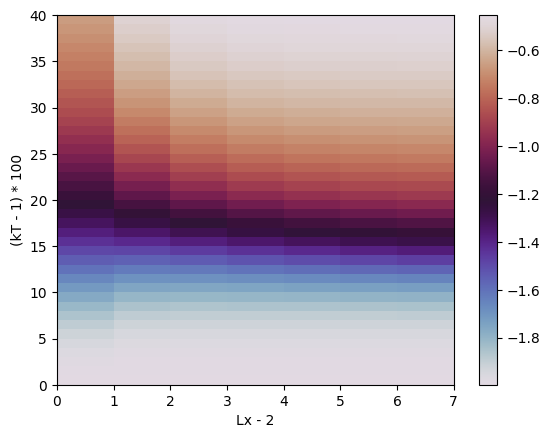

In [7]:
import matplotlib.pyplot as plt
data = np.load("matrix_of_mean_energies.txt.npy")
plt.pcolormesh(np.transpose(data), cmap='twilight')
plt.xlabel('Lx - 2')
plt.ylabel('(kT - 1) * 100')
plt.colorbar()
plt.show()